# Bended gaussian in length space

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import fastkde
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture

In [2]:

def CCS_from_K0_inv(K0_inv, charge, mass):
    mass = mass + charge * 1.00727647 # in g/mol
    CCS = K0_inv / (np.sqrt(305 * mass * 28.014 / (28.014 + mass)) * 1/18500 * 1/charge)
    return CCS # in Angstrom^2


In [3]:
root_path = os.getenv("DATA_DIR")
#data_path = os.path.join(root_path, "SourceData_Figure_1.csv")
#data = pd.read_csv(data_path)
data = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_aligned_train_v2660.pkl"))

In [4]:
#remove contaminants
data = data[data["Potential contaminant"].isna()]
#remove decoys
data = data[data["Reverse"].isna()]
#remove intenssity = 0
data = data[data["Intensity"] > 0]

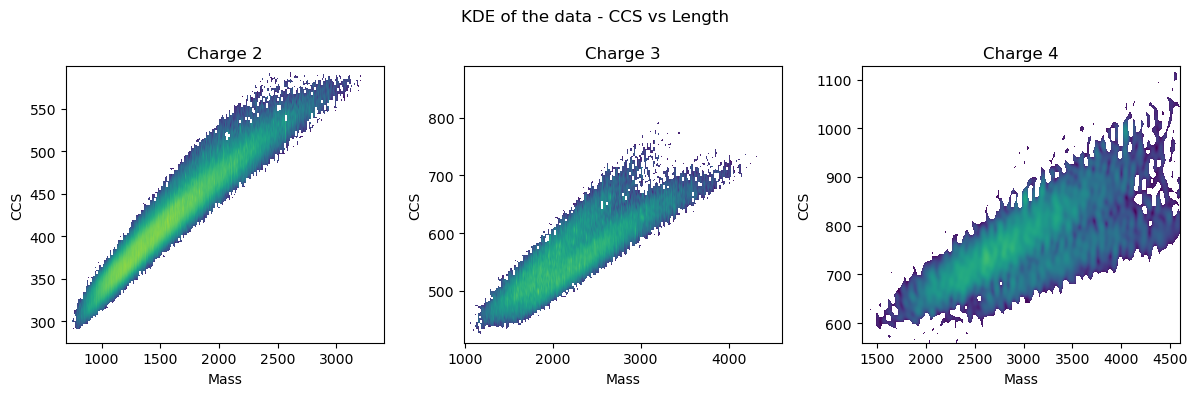

In [5]:
#plot the kde of the data
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, charge in enumerate([2, 3, 4]):
    data_charge = data[data["Charge"] == charge]
    mass = data_charge["Mass"].values
    ccs = data_charge["CCS"].values
    pdf = fastkde.pdf(mass, ccs, num_points=1025)
    #mask out 0 values for better visualization
    pdf = np.ma.masked_where(pdf < 1e-7, pdf)
    ax[i].imshow(pdf, origin='lower', aspect='auto', extent=[mass.min(), mass.max(), ccs.min(), ccs.max()],norm=LogNorm(vmin=1e-7, vmax=1e-4))
    ax[i].set_xlabel("Mass")
    ax[i].set_ylabel("CCS")
    ax[i].set_title(f"Charge {charge}")
    #suptitle
plt.suptitle("KDE of the data - CCS vs Length")
plt.tight_layout()

In [7]:
from scipy.ndimage import gaussian_filter
import xarray as xr

Charge 2 - min: 0.0010000364054919082, max: 0.04283457108586181
Charge 3 - min: 0.0010000244918901067, max: 0.03929156699977547
Charge 4 - min: 0.0010001091636046532, max: 0.02288082035605033


Text(0.5, 1.05, 'P(CCS|Length) per charge')

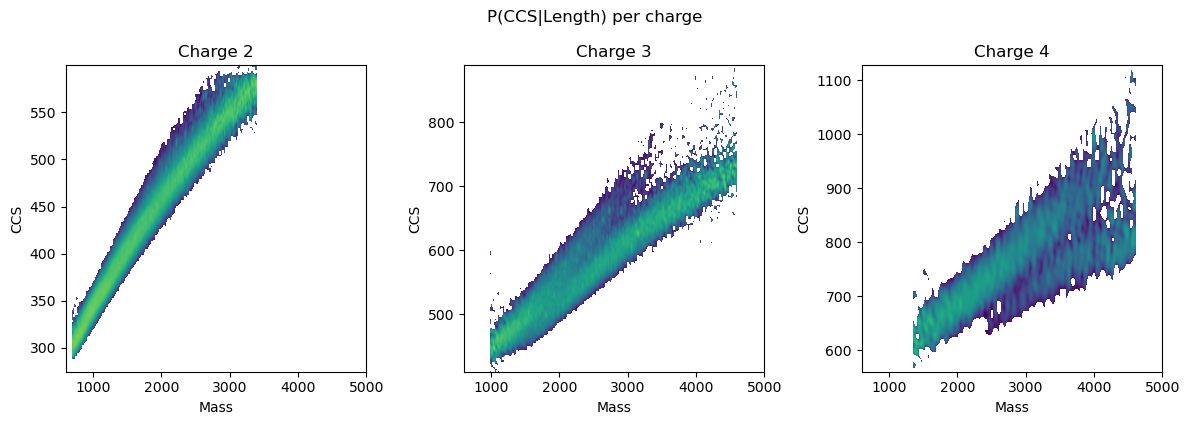

In [7]:
#plot the conditional Length distributions
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, charge in enumerate([2, 3, 4]):
    data_charge = data[data["Charge"] == charge]
    mass = data_charge["Mass"].values
    ccs = data_charge["CCS"].values
    cdf = fastkde.conditional(ccs, mass, var_names=["CCS", "Mass"], num_points=1025)
    #smooth the data and create xarray
    cdf = xr.DataArray(gaussian_filter(cdf, sigma=1), dims=["CCS","Mass"], coords={"CCS": cdf["CCS"], "Mass": cdf["Mass"]})
    #drop nans
    cdf = cdf.dropna(dim="Mass")
    #mask zero values out
    cdf = np.ma.masked_where(cdf < 1e-3, cdf)
    #print min and max values
    print(f"Charge {charge} - min: {cdf.min()}, max: {cdf.max()}")
    im1 = axs[i].imshow(cdf, origin='lower', aspect='auto', extent=[mass.min(), mass.max(),ccs.min(), ccs.max(),], norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='viridis')
    axs[i].set_xlabel("Mass")
    axs[i].set_ylabel("CCS")
    axs[i].set_title(f"Charge {charge}")
    axs[i].set_xlim(600, 5000)
plt.tight_layout()
#suptitle
plt.suptitle("P(CCS|Length) per charge", y=1.05)

## Charge 2

In [8]:
from scipy.optimize import curve_fit

In [9]:
#conditional for charge 2
data_charge = data[data["Charge"] == 2]
mass = data_charge["Mass"].values
ccs = data_charge["CCS"].values
cdf = fastkde.conditional(ccs, mass, var_names=["CCS", "Mass"], num_points=513)
#smooth the data and create xarray
cdf = xr.DataArray(gaussian_filter(cdf, sigma=1), dims=["CCS","Mass"], coords={"CCS": cdf["CCS"], "Mass": cdf["Mass"]})
#drop nans
cdf = cdf.dropna(dim="Mass")
cdf.shape

(257, 213)

In [10]:
# Model function: sum of two Gaussians
def two_gaussians(x, A1, mu1, A2, mu2, sigma):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma**2))
    return gauss1 + gauss2

A1: 0.03155834318927998, mu1: 1242.113273344385, A2: -0.0011822379997414372, mu2: 1391.3845718038285, sigma: 88.75164115917903


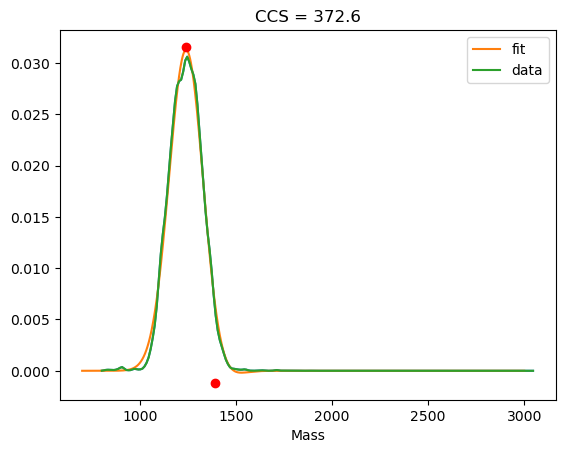

In [11]:
idx = int(3 * len(cdf) / 10)
cdf_i = cdf[idx,:]

cdf_i.plot()

peaks, properties = find_peaks(cdf_i.values, height=0.0005, prominence=0.0001)

if len(peaks) >= 2:
    #Take the highest peak
    highest_peak = np.argmax(properties["peak_heights"])
    #highest peak to the left of it
    left_peak = np.argmax(properties["peak_heights"][:highest_peak])
    heights = properties["peak_heights"][np.array([left_peak, highest_peak])]
    peaks = peaks[np.array([left_peak, highest_peak])]
    mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
    h = [cdf_i[peaks[0]], cdf_i[peaks[1]]]
if len(peaks) == 1:#take the highest peak twice
    peaks = np.array([peaks[0], peaks[0]])
    heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
    mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
    h= [cdf_i[peaks[0]], cdf_i[peaks[1]]]
if len(peaks) == 0:#take nan values
    peaks = np.array([np.nan, np.nan])
    heights = np.array([np.nan, np.nan])
    mu = [np.nan, np.nan]
    h = [np.nan, np.nan]

ax = plt.gca()

initial_guess = [heights[0], mu[0], heights[1], mu[1], 90]

popt, pcov = curve_fit(two_gaussians, cdf_i["Mass"], cdf_i.values, p0=initial_guess)

#extract the parameters
A1, mu1, A2, mu2, sigma = popt

if mu1 > mu2:
    mu1, mu2 = mu2, mu1
    A1, A2 = A2, A1

print(f"A1: {A1}, mu1: {mu1}, A2: {A2}, mu2: {mu2}, sigma: {sigma}")

#plot the fit
x = np.linspace(700, 3000, 1000)
y = two_gaussians(x, A1, mu1, A2, mu2, sigma)
plt.plot(x, y, label="fit")
plt.plot(cdf_i["Mass"], cdf_i.values, label="data")
ax.plot([mu1, mu2], [A1, A2], 'ro')
plt.legend()

No handles with labels found to put in legend.


2
A1: 0.019800732951764932, mu1: 813.3016984578351, A2: 0.019800631882739096, mu2: 813.3017233398813, sigma: 58.15065400212942
2
A1: 0.01781278922972581, mu1: 1012.3631167193932, A2: 0.017798463554479945, mu2: 1012.3784647033493, sigma: 74.06771333607655
2
A1: 0.01569054401332441, mu1: 1239.3800133995073, A2: 0.01567811818883526, mu2: 1239.3977025681263, sigma: 86.61115069083937
2
A1: 0.014463235890918413, mu1: 1463.2321592281785, A2: 0.0149690655350754, mu2: 1463.2437786500564, sigma: 99.97826809222497
2
A1: 0.013657985800970343, mu1: 1714.3139733292776, A2: 0.013312437485130793, mu2: 1714.3143607145394, sigma: 113.81616479756315
2
A1: 0.0015364958931653504, mu1: 1741.5284426183648, A2: 0.025121783544967007, mu2: 1989.4703366575372, sigma: 125.49982138302362
2
A1: 0.0035725450438069163, mu1: 1992.9785814989852, A2: 0.025516126638187028, mu2: 2276.4710521664574, sigma: 123.74627931863999
2
A1: 0.002527378488455331, mu1: 2216.2025593304297, A2: 0.026941905738165753, mu2: 2581.9129923033

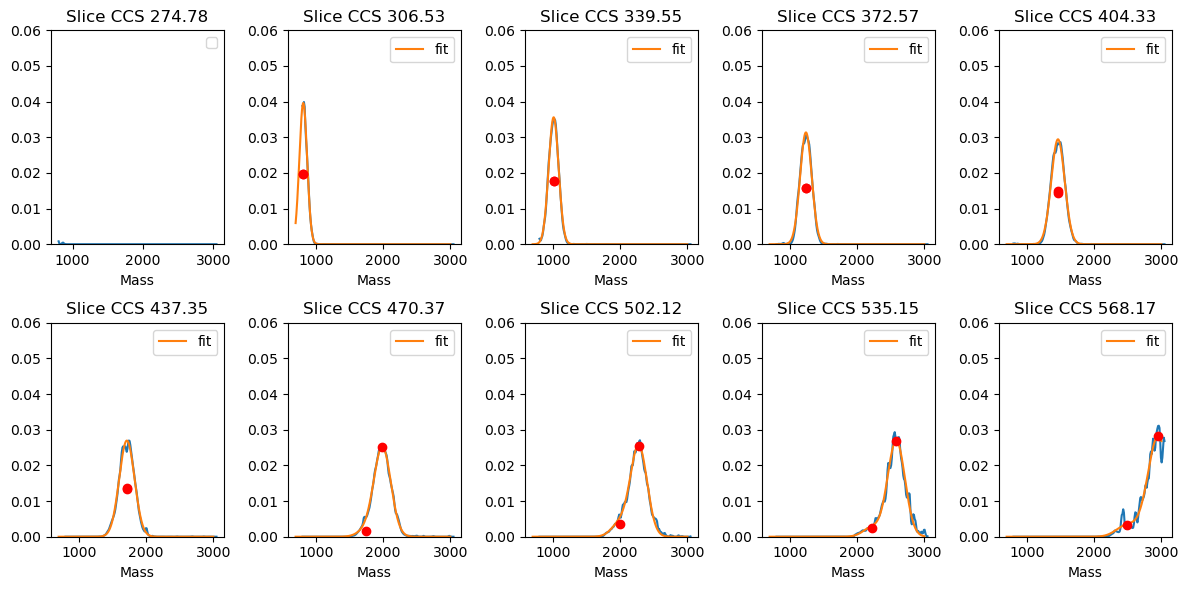

In [12]:
#create 10 plots of the conditional distribution
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(10):
    ax = axs.flatten()[i]
    #get index of 1/10 of the data
    idx = int(i * len(cdf) / 10)
    cdf_i = cdf[idx,:]
    peaks, properties = find_peaks(cdf_i.values, height=0.001, prominence=0.0001, distance = 10)
    #take the highest peak
    if len(peaks) >= 2:
        #Take the highest peak
        highest_peak = np.argmax(properties["peak_heights"])
        #highest peak to the left of it
        try:
            left_peak = np.argmax(properties["peak_heights"][:highest_peak])
        except ValueError:
            left_peak = np.argmax(properties["peak_heights"][highest_peak:])
        heights = properties["peak_heights"][np.array([left_peak, highest_peak])]
        peaks = peaks[np.array([left_peak, highest_peak])]
        mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
        h = [cdf_i[peaks[0]], cdf_i[peaks[1]]]
    if len(peaks) == 1:#take the highest peak twice
        peaks = np.array([peaks[0], peaks[0]])
        heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
        mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
        h= [cdf_i[peaks[0]], cdf_i[peaks[1]]]
    if len(peaks) == 0:#take nan values
        peaks = np.array([np.nan, np.nan])
        heights = np.array([np.nan, np.nan])
        mu = [np.nan, np.nan]
        h = [np.nan, np.nan]

    cdf_i.plot(ax=ax)
    ax.set_title(f"Slice CCS {np.round(cdf_i.CCS.values,2)}")
    ax.set_ylim(0, 0.06)

    if len(peaks[~np.isnan(peaks)]) > 0:
        #Gaussian fit
        initial_guess = [heights[0], mu[0], heights[1], mu[1], 80]
        #set param bounds
        bounds = ([0, 800, 0, 800, 50], [1.0, 5000, 1.0, 5000, np.inf])
        print(len(peaks))
        popt, pcov = curve_fit(two_gaussians, cdf_i["Mass"], cdf_i.values, p0=initial_guess, bounds=bounds)
        A1, mu1, A2, mu2, sigma = popt
        #make mu1 the left peak
        if mu1 > mu2:
            mu1, mu2 = mu2, mu1
            A1, A2 = A2, A1
        print(f"A1: {A1}, mu1: {mu1}, A2: {A2}, mu2: {mu2}, sigma: {sigma}")
        x = np.linspace(700, 3000, 1000)
        y = two_gaussians(x, A1, mu1, A2, mu2, sigma)
        ax.plot(x, y, label="fit")
        ax.plot([mu1,mu2], [A1, A2], 'ro')

    ax.legend()
plt.tight_layout()

In [13]:
#fit a gaussian to each slice and store the mean 
means = []
data_charge["gaussian_left"] = np.nan
data_charge["gaussian_right"] = np.nan
for i, cdf_slice in enumerate(cdf):
    #find the peak
    peaks, properties = find_peaks(cdf_slice.values, height=0.0005, prominence=0.0001)
    #take the two highest peaks
    if len(peaks) >= 2:
        #Take the highest peak
        highest_peak = np.argmax(properties["peak_heights"])
        #highest peak to the left of it
        try:
            left_peak = np.argmax(properties["peak_heights"][:highest_peak])
        except ValueError:
            left_peak = np.argmax(properties["peak_heights"][highest_peak:])
        heights = properties["peak_heights"][np.array([left_peak, highest_peak])]
        peaks = peaks[np.array([left_peak, highest_peak])]
        mu = [cdf_slice["Mass"][peaks[0]], cdf_slice["Mass"][peaks[1]]]
        h = [cdf_slice[peaks[0]], cdf_slice[peaks[1]]]
    #take the highest peak twice
    if len(peaks) == 1:
        peaks = np.array([peaks[0], peaks[0]])
        heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
        mu = [cdf_slice["Mass"][peaks[0]], cdf_slice["Mass"][peaks[1]]]
        h= [cdf_slice[peaks[0]], cdf_slice[peaks[1]]]
    #take nan values
    if len(peaks) == 0:
        means.append(np.nan)
        means.append(np.nan)
        continue
    #Gaussian fit
    initial_guess = [heights[0], mu[0], heights[1], mu[1], 90]
    #set param bounds
    bounds = ([0, 900, 0, 900, 50], [1.0, 3200, 1.0, 3200, np.inf])
    try :
        popt, pcov = curve_fit(two_gaussians, cdf_slice["Mass"], cdf_slice.values, p0=initial_guess, bounds=bounds)
    except RuntimeError:# at the beggining there're no two gaussians so it fails
        means.append(np.nan)
        means.append(np.nan)
        continue
    except ValueError:# at the beggining there're no two gaussians so it fails
        means.append(np.nan)
        means.append(np.nan)
        continue
    
    A1, mu1, A2, mu2, sigma = popt

    #make mu1 the left peak
    if mu1 > mu2:
        mu1, mu2 = mu2, mu1
        A1, A2 = A2, A1
        
    #if mu2 < mu1 + 1:#if the two peaks are too close the fitting didn't work
    #    means.append(np.nan)
    #    means.append(np.nan)
    #    continue
    means.append(mu1)
    means.append(mu2)
    
    #get the edges of the ccs bin
    if i < len(cdf) - 1:
        ccs_left = cdf["CCS"].values[i] 
        ccs_right = cdf["CCS"].values[i+1]
    else:
        continue

    #get the rows in data_charge that are in the ccs bin
    mask = (data_charge["CCS"] >= ccs_left) & (data_charge["CCS"] < ccs_right)
    #define gaussina left
    gauss_left = lambda x: A1 * np.exp(-(x - mu1)**2 / (2 * sigma**2))
    #define gaussian right
    gauss_right = lambda x: A2 * np.exp(-(x - mu2)**2 / (2 * sigma**2))
    #store the values if the two means differ by at least 50
    if mu2> mu1 + 200:
        data_charge.loc[mask, "gaussian_left"] = gauss_left(data_charge.loc[mask, "Mass"])
        data_charge.loc[mask, "gaussian_right"] = gauss_right(data_charge.loc[mask, "Mass"])
    else:
        data_charge.loc[mask, "gaussian_left"] = 0.0
        data_charge.loc[mask, "gaussian_right"] = gauss_right(data_charge.loc[mask, "Mass"]) 
    
    #data_charge.loc[mask, "gaussian_left"] = gauss_left(data_charge.loc[mask, "Mass"])
    #data_charge.loc[mask, "gaussian_right"] = gauss_right(data_charge.loc[mask, "Mass"])


/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on 

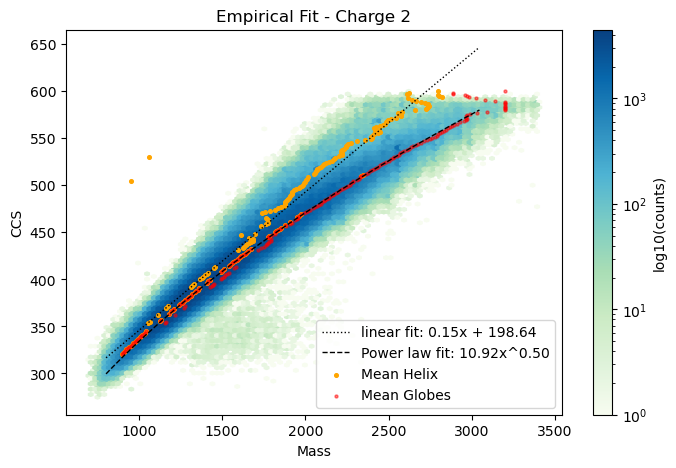

In [14]:
#plot the means on top of the data
fig, ax = plt.subplots(figsize=(8, 5))

#cdf.plot(ax=ax, norm=LogNorm(vmin=1e-3, vmax=1e-1))
#hexbin plot
hb = ax.hexbin(data_charge["Mass"], data_charge["CCS"], gridsize=100, bins='log', cmap="GnBu", mincnt=1)
fig.colorbar(hb, ax=ax, label="log10(counts)")
ax.set_xlabel("Mass")
ax.set_ylabel("CCS")
ax.set_title("Empirical Fit - Charge 2")

means = np.array(means).reshape(-1, 2)
#reorder such that the smaller value is first
means = np.sort(means, axis=1)
means_helix = np.array(means[:,0])
means_globes = np.array(means[:,1])

ax.scatter(means_helix, cdf["CCS"].values, c='orange',  label="Mean Helix", s=7.0)
ax.scatter(means_globes, cdf["CCS"].values, c='red', alpha=0.5, label="Mean Globes", s=4.5)

#fit a straight line
def straight_line(x, a, b):
    return a * x + b

#take only the non nan values
mask = ~np.isnan(means_helix)
means_valid = means_helix[mask]
cdf_valid = cdf["CCS"].values[mask]

popt, pcov = curve_fit(straight_line, means_valid, cdf_valid)
a, b = popt
x = np.linspace(cdf["Mass"].min(), cdf["Mass"].max(), 1000)
y = straight_line(x, a, b)
ax.plot(x, y, label=f"linear fit: {a:.2f}x + {b:.2f}", linewidth = 1.0, color = "black", linestyle="dotted")

#fit a power law
def power_law(x, a, b):
    return a * x**b 

#take only the non nan values
mask = ~np.isnan(means_globes)
means_valid = means_globes[mask]
cdf_valid = cdf["CCS"].values[mask]

popt, pcov = curve_fit(power_law, means_valid, cdf_valid)
a, b = popt
x = np.linspace(cdf["Mass"].min(), cdf["Mass"].max(), 1000)
y = power_law(x, a, b)
ax.plot(x, y, label=f"Power law fit: {a:.2f}x^{b:.2f}", linewidth=1.0, color="black", linestyle="--")
ax.legend()

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


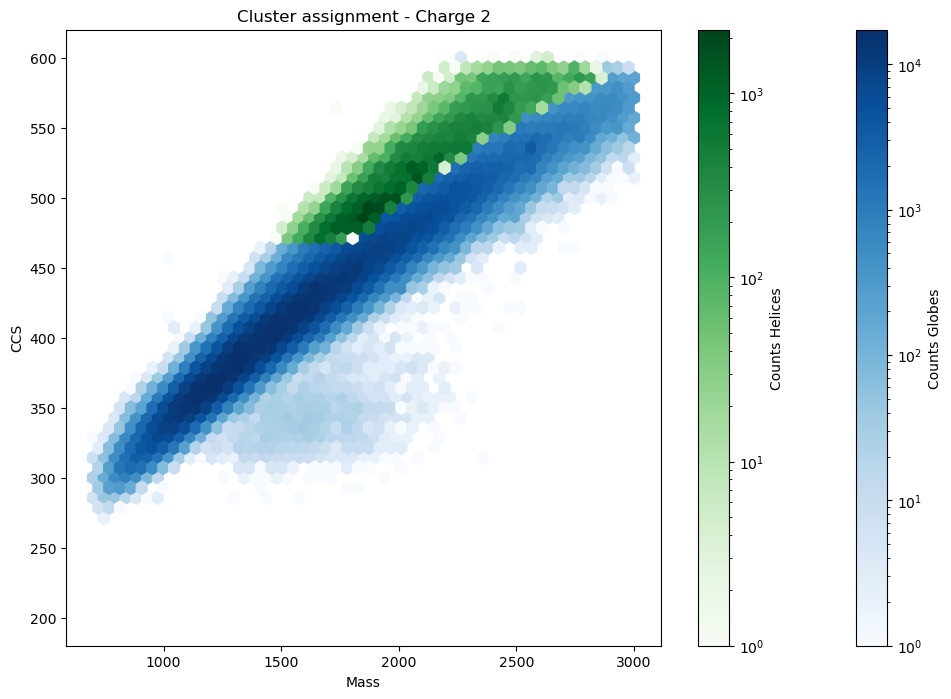

In [15]:
x = data_charge["Mass"].values
y = data_charge["CCS"].values
#assign points to either globes (right gaussian) or helix (left gaussian)
#use the gaussian that gives the highest value
mask = data_charge["gaussian_left"] > data_charge["gaussian_right"]
data_charge["Assignment"] = "Globes"
data_charge.loc[mask, "Assignment"] = "Helix"

#plot hexbin per assignment in the same figure
fig, ax = plt.subplots(figsize=(12, 8))
hb1 = ax.hexbin(data_charge[data_charge["Assignment"] == "Globes"]["Mass"], data_charge[data_charge["Assignment"] == "Globes"]["CCS"], gridsize=50, 
               cmap='Blues', label="Globes", bins='log', alpha=1.0 , extent=[700, 3000, 200, 600], mincnt=1)
hb2 = ax.hexbin(data_charge[data_charge["Assignment"] == "Helix"]["Mass"], data_charge[data_charge["Assignment"] == "Helix"]["CCS"], gridsize=50,
                cmap='Greens', label="Helix", bins='log', alpha=1.0 , extent=[700, 3000, 200, 600], mincnt=1)

ax.set_xlabel("Mass")
ax.set_ylabel("CCS")
ax.set_title("Cluster assignment - Charge 2")
plt.colorbar(hb1, label="Counts Globes")
plt.colorbar(hb2, label="Counts Helices")

In [16]:
data_2 = data_charge.copy()

## Charge 3

In [8]:
#conditional for charge 3
data_charge = data[data["Charge"] == 3]
mass = data_charge["Mass"].values
ccs = data_charge["CCS"].values
cdf = fastkde.conditional(ccs, mass, var_names=["CCS", "Mass"], num_points=513)
#smooth the data and create xarray
cdf = xr.DataArray(gaussian_filter(cdf, sigma=4), dims=["CCS","Mass"], coords={"CCS": cdf["CCS"], "Mass": cdf["Mass"]})
#drop nans
cdf = cdf.dropna(dim="Mass")
cdf.shape

(257, 197)

2
A1: 0.01348147821760109, mu1: 1656.8156772636082, A2: 0.010008546342414968, mu2: 2010.3403438295122, sigma1: 163.3835794162506, sigma2: 153.6774544935246


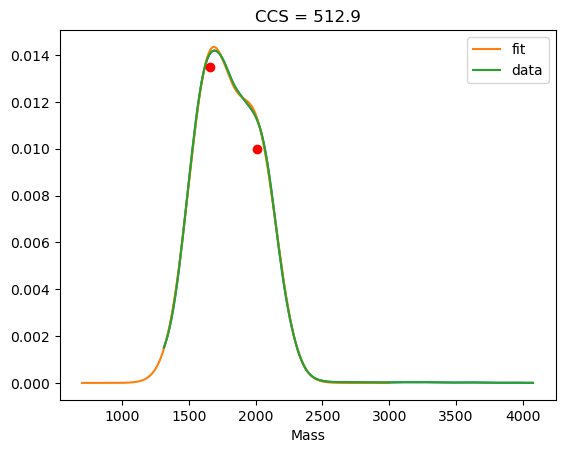

In [9]:
idx = int(2 * len(cdf) / 10)
cdf_i = cdf[55,:]

cdf_i.plot()

peaks, properties = find_peaks(cdf_i.values, height=0.0005, prominence=0.0001)

if len(peaks) >= 2:
    #Take the highest peak
    highest_peak = np.argmax(properties["peak_heights"])
    #highest peak to the left of it
    try:
        left_peak = np.argmax(properties["peak_heights"][:highest_peak])
    except ValueError:
        left_peak = np.argmax(properties["peak_heights"][highest_peak:])
    heights = properties["peak_heights"][np.array([left_peak, highest_peak])]
    peaks = peaks[np.array([left_peak, highest_peak])]
    mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
    h = [cdf_i[peaks[0]], cdf_i[peaks[1]]]
if len(peaks) == 1:#take the highest peak twice
    peaks = np.array([peaks[0], peaks[0]])
    heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
    mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
    h= [cdf_i[peaks[0]], cdf_i[peaks[1]]]
if len(peaks) == 0:#take nan values
    peaks = np.array([np.nan, np.nan])
    heights = np.array([np.nan, np.nan])
    mu = [np.nan, np.nan]
    h = [np.nan, np.nan]

ax = plt.gca()

# Model function: sum of two Gaussians
def two_gaussians(x, A1, mu1, A2, mu2, sigma1, sigma2):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return gauss1 + gauss2

initial_guess = [heights[0], mu[0], heights[1], mu[1], 20, 20]

#set param bounds
bounds = ([0, 800, 0, 800, 1, 1], [1.0, 5000, 1.0, 5000, np.inf, np.inf])
print(len(peaks))
popt, pcov = curve_fit(two_gaussians, cdf_i["Mass"], cdf_i.values, p0=initial_guess, bounds=bounds, loss='soft_l1')

#extract the parameters
A1, mu1, A2, mu2, sigma1, sigma2 = popt

if mu1 > mu2:
    mu1, mu2 = mu2, mu1
    A1, A2 = A2, A1
    sigma1, sigma2 = sigma2, sigma1

print(f"A1: {A1}, mu1: {mu1}, A2: {A2}, mu2: {mu2}, sigma1: {sigma1}, sigma2: {sigma2}")

#plot the fit
x = np.linspace(700, 3000, 1000)
y = two_gaussians(x, A1, mu1, A2, mu2, sigma1, sigma2)
plt.plot(x, y, label="fit")
plt.plot(cdf_i["Mass"], cdf_i.values, label="data")
ax.plot([mu1, mu2], [A1, A2], 'ro')
plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


A1: 0.015012201440655038, mu1: 1613.509091262546, A2: 0.008700939502964059, mu2: 1956.8569406470294, sigma1: 165.1393344236635, sigma2: 150.6092416144299
A1: 0.00845079235068299, mu1: 1940.3325838598935, A2: 0.012872614291312104, mu2: 2347.343745116388, sigma1: 165.94719733391054, sigma2: 172.91822728028308
A1: 0.006060562716165603, mu1: 2234.5669694173916, A2: 0.014309917470560894, mu2: 2771.61829926052, sigma1: 162.7376455532463, sigma2: 200.44720132584501
A1: 0.004054600049906447, mu1: 2541.5292845056038, A2: 0.016333005651454204, mu2: 3272.305561562367, sigma1: 157.88248452236186, sigma2: 244.02006954347308
A1: 0.0021479386431585033, mu1: 2884.162998577102, A2: 0.016200655818434773, mu2: 3913.472355868012, sigma1: 247.56838434033818, sigma2: 321.28660782720556
A1: 0.0011806474967321282, mu1: 3088.777897248838, A2: 0.08591459076528837, mu2: 5999.99994298491, sigma1: 173.49360548776, sigma2: 830.9383441737385


No handles with labels found to put in legend.


A1: 0.0008205975252681875, mu1: 3407.666255563577, A2: 0.0011084589541882532, mu2: 4043.4199767507575, sigma1: 231.36933274183895, sigma2: 165.84323398072414


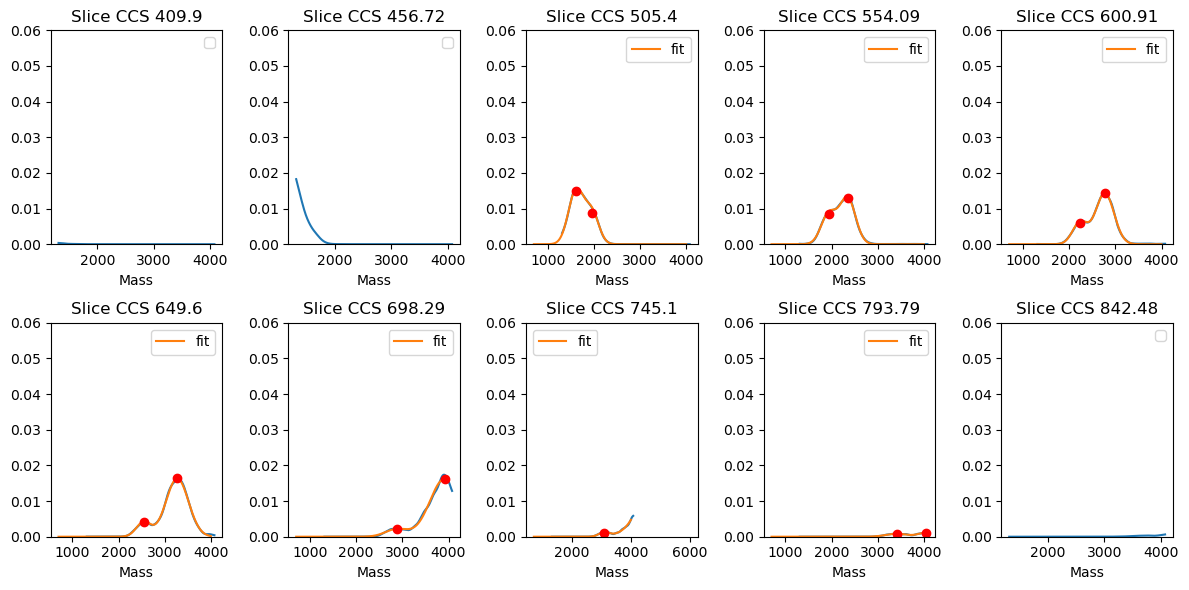

In [10]:
#create 10 plots of the conditional distribution
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(10):
    ax = axs.flatten()[i]
    #get index of 1/10 of the data
    idx = int(i * len(cdf) / 10)
    cdf_i = cdf[idx,:]
    peaks, properties = find_peaks(cdf_i.values, height=0.0005, prominence=0.0001)
    #take the highest peak
    if len(peaks) >= 2:
        #Take the highest peak
        highest_peak = np.argmax(properties["peak_heights"])
        #highest peak to the left of it
        try:
            left_peak = np.argmax(properties["peak_heights"][:highest_peak])
        except ValueError:
            left_peak = np.argmax(properties["peak_heights"][highest_peak:])
        heights = properties["peak_heights"][np.array([left_peak, highest_peak])]
        peaks = peaks[np.array([left_peak, highest_peak])]
        mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
        h = [cdf_i[peaks[0]], cdf_i[peaks[1]]]
    if len(peaks) == 1:#take the highest peak twice
        peaks = np.array([peaks[0], peaks[0]])
        heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
        mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
        h= [cdf_i[peaks[0]], cdf_i[peaks[1]]]
    if len(peaks) == 0:#take nan values
        peaks = np.array([np.nan, np.nan])
        heights = np.array([np.nan, np.nan])
        mu = [np.nan, np.nan]
        h = [np.nan, np.nan]

    cdf_i.plot(ax=ax)
    ax.set_title(f"Slice CCS {np.round(cdf_i.CCS.values,2)}")
    ax.set_ylim(0, 0.06)

    if len(peaks[~np.isnan(peaks)]) > 0:
        #Gaussian fit
        initial_guess = [heights[0], mu[0], heights[1], mu[1], 80, 80]
        #set param bounds
        bounds = ([0.0, 800, 0, 800, 50,50], [1.0, 5000, 1.0, 6000, np.inf, np.inf])
        try :
            popt, pcov = curve_fit(two_gaussians, cdf_i["Mass"], cdf_i.values, p0=initial_guess, bounds=bounds, loss='soft_l1')
        except RuntimeError:# at the beggining there're no two gaussians so it fails
            means.append(np.nan)
            means.append(np.nan)
            continue
        except ValueError:
            means.append(np.nan)
            means.append(np.nan)
            continue
        A1, mu1, A2, mu2, sigma1, sigma2 = popt
        #make mu1 the left peak
        if mu1 > mu2:
            mu1, mu2 = mu2, mu1
            A1, A2 = A2, A1
            sigma1, sigma2 = sigma2, sigma1
        print(f"A1: {A1}, mu1: {mu1}, A2: {A2}, mu2: {mu2}, sigma1: {sigma1}, sigma2: {sigma2}")
        x = np.linspace(700, 4000, 1000)
        y = two_gaussians(x, A1, mu1, A2, mu2, sigma1, sigma2)
        ax.plot(x, y, label="fit")
        ax.plot([mu1,mu2], [A1, A2], 'ro')

    ax.legend()
plt.tight_layout()

In [11]:
def two_gaussians(x, A1, mu1, A2, mu2, sigma1, sigma2):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return gauss1 + gauss2

In [12]:
#fit a gaussian to each slice and store the mean 
means = []
data_charge["gaussian_left"] = np.nan
data_charge["gaussian_right"] = np.nan
for i, cdf_slice in enumerate(cdf):
    #find the peak
    peaks, properties = find_peaks(cdf_slice.values, height=0.0005, prominence=0.0001)
    #take the two highest peaks
    if len(peaks) >= 2:
        #Take the highest peak
        highest_peak = np.argmax(properties["peak_heights"])
        #highest peak to the left of it
        try:
            left_peak = np.argmax(properties["peak_heights"][:highest_peak])
        except ValueError:
            left_peak = np.argmax(properties["peak_heights"][highest_peak:])
        heights = properties["peak_heights"][np.array([left_peak, highest_peak])]
        peaks = peaks[np.array([left_peak, highest_peak])]
        mu = [cdf_slice["Mass"][peaks[0]], cdf_slice["Mass"][peaks[1]]]
        h = [cdf_slice[peaks[0]], cdf_slice[peaks[1]]]
    #take the highest peak twice
    if len(peaks) == 1:
        peaks = np.array([peaks[0], peaks[0]])
        heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
        mu = [cdf_slice["Mass"][peaks[0]], cdf_slice["Mass"][peaks[1]]]
        h= [cdf_slice[peaks[0]], cdf_slice[peaks[1]]]
    #take nan values
    if len(peaks) == 0:
        means.append(np.nan)
        means.append(np.nan)
        continue
    #Gaussian fit
    initial_guess = [heights[0], mu[0], heights[1], mu[1], 80, 80]
    #set param bounds
    bounds = ([0.0, 1000, 0, 1000, 50, 50], [1.0, 4000, 1.0, 4000, np.inf, np.inf])
    try :
        popt, pcov = curve_fit(two_gaussians, cdf_slice["Mass"], cdf_slice.values, p0=initial_guess, bounds=bounds, loss='soft_l1')
    except RuntimeError:# at the beggining there're no two gaussians so it fails
        means.append(np.nan)
        means.append(np.nan)
        continue
    except ValueError:
        means.append(np.nan)
        means.append(np.nan)
        continue
    
    A1, mu1, A2, mu2, sigma1, sigma2 = popt

    #make mu1 the left peak
    if mu1 > mu2:
        mu1, mu2 = mu2, mu1
        A1, A2 = A2, A1
        sigma1, sigma2 = sigma2, sigma1
    if mu2 < mu1 + 200:#if the two peaks are too close the fitting didn't work
        means.append(np.nan)
        means.append(np.nan)
        continue
        
    means.append(mu1)
    means.append(mu2)
    
    #get the edges of the ccs bin
    if i < len(cdf) - 1:
        ccs_left = cdf["CCS"].values[i] 
        ccs_right = cdf["CCS"].values[i+1]
    else:
        continue

    #get the rows in data_charge that are in the ccs bin
    mask = (data_charge["CCS"] >= ccs_left) & (data_charge["CCS"] < ccs_right)
    #define gaussina left
    gauss_left = lambda x: A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    #define gaussian right
    gauss_right = lambda x: A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    
    data_charge.loc[mask, "gaussian_left"] = gauss_left(data_charge.loc[mask, "Mass"])
    data_charge.loc[mask, "gaussian_right"] = gauss_right(data_charge.loc[mask, "Mass"])

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on 

In [14]:
plt.style.use('science')

(800.0, 4500.0)

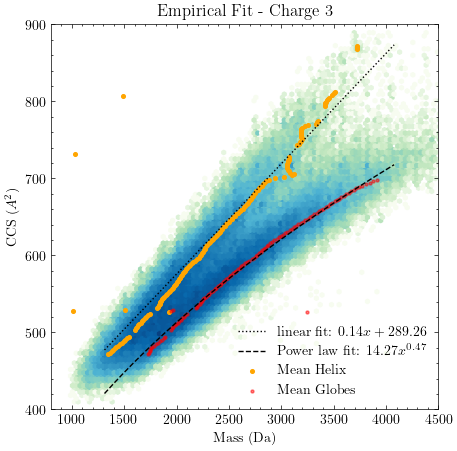

In [17]:
#plot the means on top of the data
fig, ax = plt.subplots(figsize=(5, 5))

hb = ax.hexbin(data_charge["Mass"], data_charge["CCS"], gridsize=100, bins='log', cmap="GnBu", mincnt=1)
#fig.colorbar(hb, ax=ax, label="log10(counts)")
ax.set_xlabel("Mass (Da)")
ax.set_ylabel("CCS ($A^2$)")
ax.set_title("Charge 3 - Empirical Fit")

means = np.array(means).reshape(-1, 2)
#reorder such that the smaller value is first
means = np.sort(means, axis=1)
means_helix = np.array(means[:,0])
means_globes = np.array(means[:,1])

#ccs values < 700
mask = cdf["CCS"].values < 700


ax.scatter(means_helix, cdf["CCS"].values, c='orange',  label="Mean Helix", s=7.0)
ax.scatter(means_globes[mask], cdf["CCS"].values[mask], c='red', alpha=0.5, label="Mean Globes", s=4.5)

#fit a straight line
def straight_line(x, a, b):
    return a * x + b



#take only the non nan values
mask = ~np.isnan(means_helix)
means_valid = means_helix[mask]
cdf_valid = cdf["CCS"].values[mask]


popt, pcov = curve_fit(straight_line, means_valid, cdf_valid)
a, b = popt
x = np.linspace(cdf["Mass"].min(), cdf["Mass"].max(), 1000)
y = straight_line(x, a, b)
ax.plot(x, y, label=f"linear fit: ${{{a:.2f}}}x + {{{b:.2f}}}$", linewidth = 1.0, color = "black", linestyle="dotted")

#fit a power law
def power_law(x, a, b):
    return a * x**b 

#take only the non nan values
mask = ~np.isnan(means_globes)
means_valid = means_globes[mask]
cdf_valid = cdf["CCS"].values[mask]
mask = cdf_valid < 700
means_valid = means_valid[mask]
cdf_valid = cdf_valid[mask]
popt, pcov = curve_fit(power_law, means_valid, cdf_valid)
a, b = popt
x = np.linspace(cdf["Mass"].min(), cdf["Mass"].max(), 1000)
y = power_law(x, a, b)
ax.plot(x, y, label=f"Power law fit: ${{{a:.2f}}}x^{{{b:.2f}}}$", linewidth=1.0, color="black", linestyle="--")
ax.legend()
#title
ax.set_title("Empirical Fit - Charge 3")
ax.set_ylim(400,900)
ax.set_xlim(800, 4500)

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


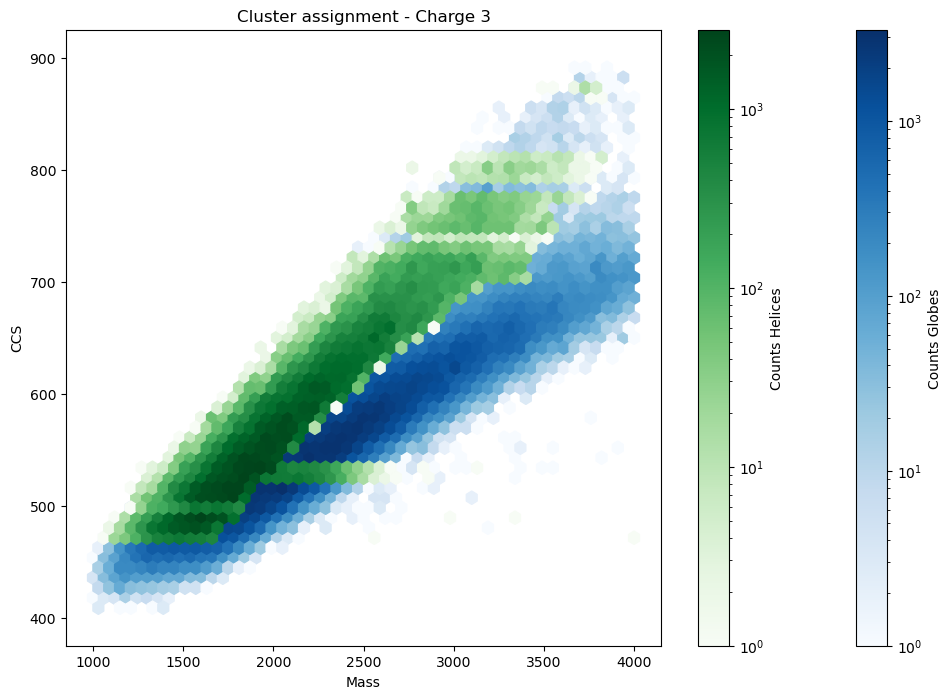

In [23]:
x = data_charge["Mass"].values
y = data_charge["CCS"].values
#assign points to either globes (right gaussian) or helix (left gaussian)
#use the gaussian that gives the highest value
mask = data_charge["gaussian_left"] > data_charge["gaussian_right"] 
data_charge["Assignment"] = "Globes"
data_charge.loc[mask, "Assignment"] = "Helix"

#plot hexbin per assignment in the same figure
fig, ax = plt.subplots(figsize=(12, 8))
hb1 = ax.hexbin(data_charge[data_charge["Assignment"] == "Globes"]["Mass"], data_charge[data_charge["Assignment"] == "Globes"]["CCS"], gridsize=50, 
               cmap='Blues', label="Globes", bins='log', alpha=1.0 , extent=[1000, 4000, 400, 900], mincnt=1)
hb2 = ax.hexbin(data_charge[data_charge["Assignment"] == "Helix"]["Mass"], data_charge[data_charge["Assignment"] == "Helix"]["CCS"], gridsize=50,
                cmap='Greens', label="Helix", bins='log', alpha=1.0 , extent=[1000, 4000, 400, 900], mincnt=1)

ax.set_xlabel("Mass")
ax.set_ylabel("CCS")
ax.set_title("Cluster assignment - Charge 3")
plt.colorbar(hb1, label="Counts Globes")
plt.colorbar(hb2, label="Counts Helices")

In [24]:
data_3 = data_charge.copy()

## Charge 4

In [25]:
#conditional for charge 3
data_charge = data[data["Charge"] == 4]
mass = data_charge["Mass"].values
ccs = data_charge["CCS"].values
cdf = fastkde.conditional(ccs, mass, var_names=["CCS", "Mass"], num_points=513)
#smooth the data and create xarray
cdf = xr.DataArray(gaussian_filter(cdf, sigma=4.0), dims=["CCS","Mass"], coords={"CCS": cdf["CCS"], "Mass": cdf["Mass"]})
#drop nans
cdf = cdf.dropna(dim="Mass")
cdf.shape

(257, 221)

2
A1: 0.013447561790472027, mu1: 2266.028196496821, A2: 0.0025040788882739235, mu2: 3145.8070146734267, sigma: 258.86470272416517


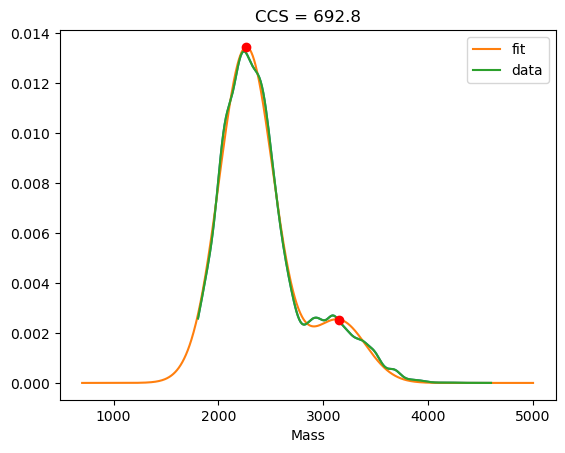

In [26]:
idx = int(2 * len(cdf) / 10)
cdf_i = cdf[60,:]

cdf_i.plot()

peaks, properties = find_peaks(cdf_i.values, height=0.0005, prominence=0.0001)

if len(peaks) >= 2:
    #Take the highest peak
    highest_peak = np.argmax(properties["peak_heights"])
    #highest peak to the left of it
    try:
        right_peak =  np.argmax(properties["peak_heights"][highest_peak + 1:]) + highest_peak + 1
    except ValueError:
            right_peak = np.argmax(properties["peak_heights"][:highest_peak])
    heights = properties["peak_heights"][np.array([right_peak, highest_peak])]
    peaks = peaks[np.array([right_peak, highest_peak])]
    mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
    h = [cdf_i[peaks[0]], cdf_i[peaks[1]]]
if len(peaks) == 1:#take the highest peak twice
    peaks = np.array([peaks[0], peaks[0]])
    heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
    mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
    h= [cdf_i[peaks[0]], cdf_i[peaks[1]]]
if len(peaks) == 0:#take nan values
    peaks = np.array([np.nan, np.nan])
    heights = np.array([np.nan, np.nan])
    mu = [np.nan, np.nan]
    h = [np.nan, np.nan]

ax = plt.gca()

# Model function: sum of two Gaussians
def two_gaussians(x, A1, mu1, A2, mu2, sigma):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma**2))
    return gauss1 + gauss2

initial_guess = [heights[0], mu[0], heights[1], mu[1], 90]

#set param bounds
bounds = ([0, 800, 0, 800, 50], [1.0, 5000, 1.0, 5000, np.inf])
print(len(peaks))
popt, pcov = curve_fit(two_gaussians, cdf_i["Mass"], cdf_i.values, p0=initial_guess, bounds=bounds)

#extract the parameters
A1, mu1, A2, mu2, sigma = popt

if mu1 > mu2:
    mu1, mu2 = mu2, mu1
    A1, A2 = A2, A1

print(f"A1: {A1}, mu1: {mu1}, A2: {A2}, mu2: {mu2}, sigma: {sigma}")

#plot the fit
x = np.linspace(700, 5000, 1000)
y = two_gaussians(x, A1, mu1, A2, mu2, sigma)
plt.plot(x, y, label="fit")
plt.plot(cdf_i["Mass"], cdf_i.values, label="data")
ax.plot([mu1, mu2], [A1, A2], 'ro')
plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


A1: 0.013826053401901756, mu1: 2105.242593153327, A2: 0.001903976323850152, mu2: 2966.769435871676, sigma: 258.9728111761411
A1: 0.012007500497962608, mu1: 2587.0077084482064, A2: 0.0043840088069234395, mu2: 3518.6865244219784, sigma: 255.49839509163056
A1: 0.008156664227521157, mu1: 3053.863203252244, A2: 0.007056397354623135, mu2: 4313.925511477101, sigma: 349.5053898075028
A1: 0.007274155910058427, mu1: 3426.7305368289635, A2: 0.0037448828432073036, mu2: 4410.819471414515, sigma: 295.30019130582156
A1: 0.004861277218211146, mu1: 3878.9669978006327, A2: 0.003697778976201833, mu2: 4999.999999999999, sigma: 329.0440446543402
A1: 0.0015256299954744938, mu1: 3873.3994126848115, A2: 0.0030600682795804825, mu2: 4279.968803630341, sigma: 211.2387374674244


No handles with labels found to put in legend.


A1: 0.001331097023464967, mu1: 4067.5003108742826, A2: 0.0016607400746728358, mu2: 4391.984078206018, sigma: 116.69519568879909


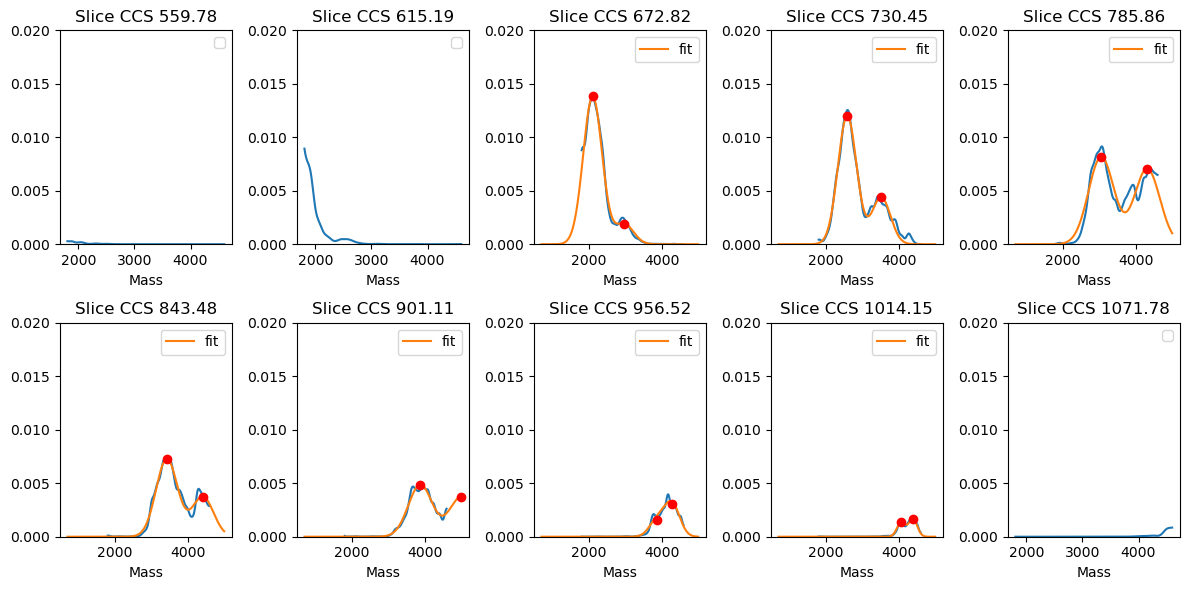

In [27]:
#create 10 plots of the conditional distribution
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(10):
    ax = axs.flatten()[i]
    #get index of 1/10 of the data
    idx = int(i * len(cdf) / 10)
    cdf_i = cdf[idx,:]
    peaks, properties = find_peaks(cdf_i.values, height=0.001, prominence=0.0001, distance = 10)
    #take the highest peak
    if len(peaks) >= 2:
        #Take the highest peak
        highest_peak = np.argmax(properties["peak_heights"])
        #highest peak to the left of it
        try:
            right_peak =  np.argmax(properties["peak_heights"][highest_peak + 1:]) + highest_peak + 1
        except ValueError:
            right_peak = np.argmax(properties["peak_heights"][:highest_peak])
        heights = properties["peak_heights"][np.array([right_peak, highest_peak])]
        peaks = peaks[np.array([right_peak, highest_peak])]
        mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
        h = [cdf_i[peaks[0]], cdf_i[peaks[1]]]
    if len(peaks) == 1:#take the highest peak twice
        peaks = np.array([peaks[0], peaks[0]])
        heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
        mu = [cdf_i["Mass"][peaks[0]], cdf_i["Mass"][peaks[1]]]
        h= [cdf_i[peaks[0]], cdf_i[peaks[1]]]
    if len(peaks) == 0:#take nan values
        peaks = np.array([np.nan, np.nan])
        heights = np.array([np.nan, np.nan])
        mu = [np.nan, np.nan]
        h = [np.nan, np.nan]

    cdf_i.plot(ax=ax)
    ax.set_title(f"Slice CCS {np.round(cdf_i.CCS.values,2)}")
    ax.set_ylim(0, 0.02)

    if len(peaks[~np.isnan(peaks)]) > 0:
        #Gaussian fit
        initial_guess = [heights[0], mu[0], heights[1], mu[1], 200]
        #set param bounds
        bounds = ([0, 800, 0, 800, 50], [1.0, 5000, 1.0, 5000, np.inf])
        popt, pcov = curve_fit(two_gaussians, cdf_i["Mass"], cdf_i.values, p0=initial_guess, bounds=bounds)
        A1, mu1, A2, mu2, sigma = popt
        #make mu1 the left peak
        if mu1 > mu2:
            mu1, mu2 = mu2, mu1
            A1, A2 = A2, A1
        print(f"A1: {A1}, mu1: {mu1}, A2: {A2}, mu2: {mu2}, sigma: {sigma}")
        x = np.linspace(700, 5000, 1000)
        y = two_gaussians(x, A1, mu1, A2, mu2, sigma)
        ax.plot(x, y, label="fit")
        ax.plot([mu1,mu2], [A1, A2], 'ro')

    ax.legend()
plt.tight_layout()

In [28]:
# Model function: sum of two Gaussians
def two_gaussians(x, A1, mu1, A2, mu2, sigma):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma**2))
    return gauss1 + gauss2

In [29]:
#fit a gaussian to each slice and store the mean 
means = []
data_charge["gaussian_left"] = np.nan
data_charge["gaussian_right"] = np.nan
for i, cdf_slice in enumerate(cdf):
    
    #find the peak
    peaks, properties = find_peaks(cdf_slice.values, height=0.0005, prominence=0.0001)
    #take the two highest peaks
    if len(peaks) >= 2:
        #Take the highest peak
        highest_peak = np.argmax(properties["peak_heights"])
        try:
            right_peak =  np.argmax(properties["peak_heights"][highest_peak + 1:]) + highest_peak + 1
        except ValueError:
            right_peak = np.argmax(properties["peak_heights"][:highest_peak])
        heights = properties["peak_heights"][np.array([right_peak, highest_peak])]
        peaks = peaks[np.array([right_peak, highest_peak])]
        mu = [cdf_slice["Mass"][peaks[0]], cdf_slice["Mass"][peaks[1]]]
        h = [cdf_slice[peaks[0]], cdf_slice[peaks[1]]]
    #take the highest peak twice
    if len(peaks) == 1:
        peaks = np.array([peaks[0], peaks[0]])
        heights = np.array([properties["peak_heights"][0], properties["peak_heights"][0]])
        mu = [cdf_slice["Mass"][peaks[0]], cdf_slice["Mass"][peaks[1]]]
        h= [cdf_slice[peaks[0]], cdf_slice[peaks[1]]]
    #take nan values
    if len(peaks) == 0:
        means.append(np.nan)
        means.append(np.nan)
        continue
    #Gaussian fit
    initial_guess = [heights[0], mu[0], heights[1], mu[1], 90]
    #set param bounds
    bounds = ([0, 1500, 0, 1500, 50], [1.0, 4500, 1.0, 4500, np.inf])
    try :
        popt, pcov = curve_fit(two_gaussians, cdf_slice["Mass"], cdf_slice.values, p0=initial_guess, bounds=bounds)
    except RuntimeError:# at the beggining there're no two gaussians so it fails
        means.append(np.nan)
        means.append(np.nan)
        continue
    except ValueError:
        means.append(np.nan)
        means.append(np.nan)
        continue
    
    A1, mu1, A2, mu2, sigma = popt

    #make mu1 the left peak
    if mu1 > mu2:
        mu1, mu2 = mu2, mu1
        A1, A2 = A2, A1
    
    if mu2 < mu1 + 200:#if the two peaks are too close the fitting didn't work
        means.append(np.nan)
        means.append(np.nan)
        continue

    means.append(mu1)
    means.append(mu2)
        
    
    #get the edges of the ccs bin
    if i < len(cdf) - 1:
        ccs_left = cdf["CCS"].values[i] 
        ccs_right = cdf["CCS"].values[i+1]
    else:
        continue

    #get the rows in data_charge that are in the ccs bin
    mask = (data_charge["CCS"] >= ccs_left) & (data_charge["CCS"] < ccs_right)
    #define gaussina left
    gauss_left = lambda x: A1 * np.exp(-(x - mu1)**2 / (2 * sigma**2))
    #define gaussian right
    gauss_right = lambda x: A2 * np.exp(-(x - mu2)**2 / (2 * sigma**2))
    #store the values if the two means differ by at least 50
    data_charge.loc[mask, "gaussian_left"] = gauss_left(data_charge.loc[mask, "Mass"])
    data_charge.loc[mask, "gaussian_right"] = gauss_right(data_charge.loc[mask, "Mass"])

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on 

(500.0, 1100.0)

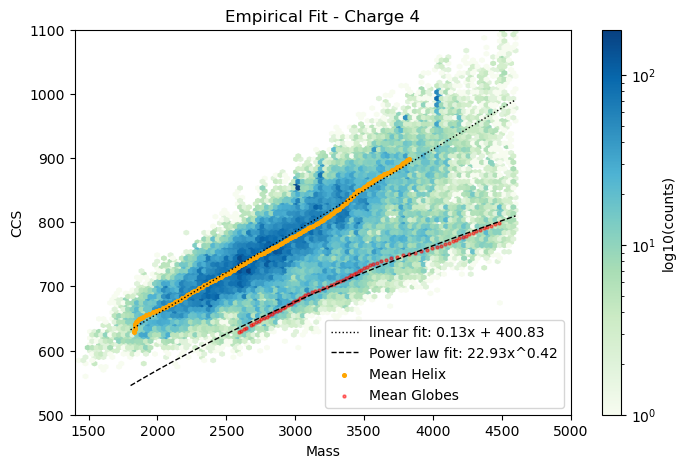

In [30]:
#plot the means on top of the data
fig, ax = plt.subplots(figsize=(8,5))

#cdf.plot(ax=ax, norm=LogNorm(vmin=1e-3, vmax=1e-1))
hb = ax.hexbin(data_charge["Mass"], data_charge["CCS"], gridsize=100, bins='log', cmap="GnBu", mincnt=1)
fig.colorbar(hb, ax=ax, label="log10(counts)")
ax.set_xlabel("Mass")
ax.set_ylabel("CCS")
ax.set_title("Empirical Fit - Charge 4")

means = np.array(means).reshape(-1, 2)
#reorder such that the smaller value is first
means = np.sort(means, axis=1)
means_helix = np.array(means[:,0])
mask = cdf["CCS"].values < 900#no reliable data above 900
ax.scatter(means_helix[mask], cdf["CCS"].values[mask], c='orange',  label="Mean Helix", s=7.0)
means_globes = np.array(means[:,1])
mask = cdf["CCS"].values < 800#no reliable data for right gaussian above 800
ax.scatter(means_globes[mask], cdf["CCS"].values[mask], c='red', alpha=0.5, label="Mean Globes", s=4.5)

#fit a straight line
def straight_line(x, a, b):
    return a * x + b



#take only the non nan values
mask = ~np.isnan(means_helix)
means_valid = means_helix[mask]
cdf_valid = cdf["CCS"].values[mask]
mask = cdf_valid < 900#no reliable data above 900
means_valid = means_valid[mask]
cdf_valid = cdf_valid[mask]


popt, pcov = curve_fit(straight_line, means_valid, cdf_valid)
a, b = popt
x = np.linspace(cdf["Mass"].min(), cdf["Mass"].max(), 1000)
y = straight_line(x, a, b)
ax.plot(x, y, label=f"linear fit: {a:.2f}x + {b:.2f}", linewidth = 1.0, color = "black", linestyle="dotted")

#fit a power law
def power_law(x, a, b):
    return a * x**b 

#take only the non nan values
mask = ~np.isnan(means_globes)
means_valid = means_globes[mask]
cdf_valid = cdf["CCS"].values[mask]
mask = cdf_valid < 800#no reliable data for right gaussian above 800
means_valid = means_valid[mask]
cdf_valid = cdf_valid[mask]
popt, pcov = curve_fit(power_law, means_valid, cdf_valid)
a, b = popt
x = np.linspace(cdf["Mass"].min(), cdf["Mass"].max(), 1000)
y = power_law(x, a, b)
ax.plot(x, y, label=f"Power law fit: {a:.2f}x^{b:.2f}", linewidth=1.0, color="black", linestyle="--")
ax.legend()
ax.set_xlim(1400, 5000)
ax.set_ylim(500, 1100)

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(500.0, 1000.0)

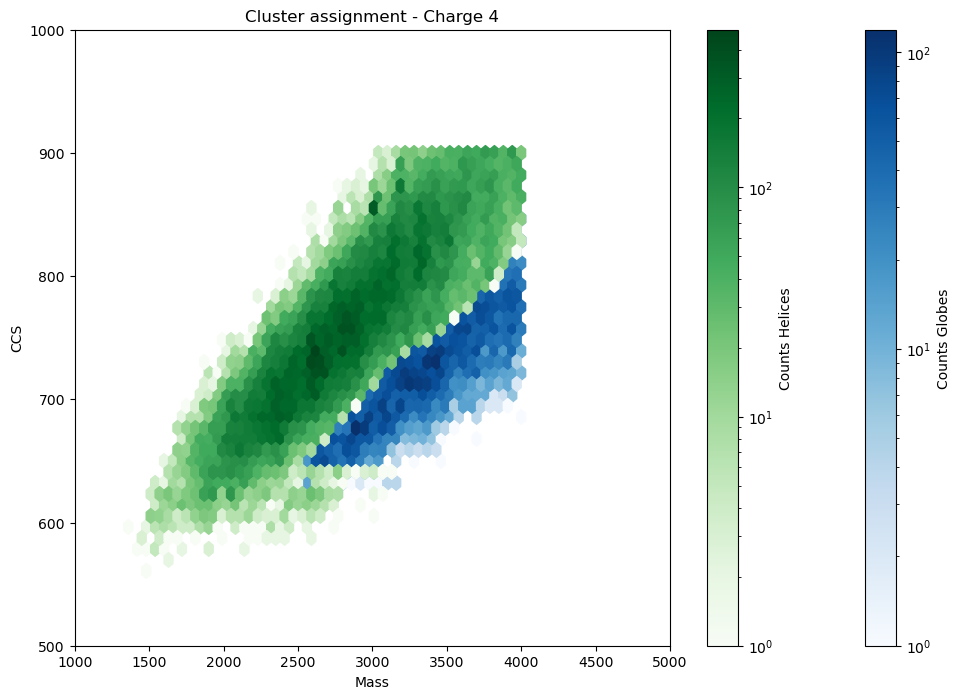

In [31]:
x = data_charge["Mass"].values
y = data_charge["CCS"].values
#assign points to either globes (right gaussian) or helix (left gaussian)
#use the gaussian that gives the highest value
mask = data_charge["gaussian_left"] < data_charge["gaussian_right"] 
data_charge["Assignment"] = "Helix"
data_charge.loc[mask, "Assignment"] = "Globes"

#plot hexbin per assignment in the same figure
fig, ax = plt.subplots(figsize=(12, 8))
hb1 = ax.hexbin(data_charge[data_charge["Assignment"] == "Globes"]["Mass"], data_charge[data_charge["Assignment"] == "Globes"]["CCS"], gridsize=50, 
               cmap='Blues', label="Globes", bins='log', alpha=1.0 , extent=[1000, 4000, 400, 900], mincnt=1)
hb2 = ax.hexbin(data_charge[data_charge["Assignment"] == "Helix"]["Mass"], data_charge[data_charge["Assignment"] == "Helix"]["CCS"], gridsize=50,
                cmap='Greens', label="Helix", bins='log', alpha=1.0 , extent=[1000, 4000, 400, 900], mincnt=1)

ax.set_xlabel("Mass")
ax.set_ylabel("CCS")
ax.set_title("Cluster assignment - Charge 4")
plt.colorbar(hb1, label="Counts Globes")
plt.colorbar(hb2, label="Counts Helices")
ax.set_xlim(1000, 5000)
ax.set_ylim(500, 1000)

In [32]:
data_charge["Assignment"].value_counts()

Helix     64114
Globes    13707
Name: Assignment, dtype: int64

In [33]:
data_4 = data_charge.copy()

# Train Set

In [34]:
#Take the most intense feature per Modified sequence, charge and Cluster assignment
train_unique = []
for charge_df in [data_2, data_3, data_4]:
    #Helix cluster
    helix = charge_df[charge_df["Assignment"] == "Helix"]
    #sort evidence by modified sequence, charge, and intensity
    helix = helix.sort_values(["Modified sequence", "Charge", "Intensity"], ascending=False)
    #group by modified sequence, charge and take the first row
    first_up = helix.groupby(["Modified sequence", "Charge"]).first().reset_index()
    first_up["regressor"] = "upper"

    #Globes cluster
    globes = charge_df[charge_df["Assignment"] == "Globes"]
    #sort evidence by modified sequence, charge, and intensity
    globes = globes.sort_values(["Modified sequence", "Charge", "Intensity"], ascending=False)
    #group by modified sequence, charge and take the first row
    first_down = globes.groupby(["Modified sequence", "Charge"]).first().reset_index()  
    first_down["regressor"] = "lower"
    train_unique.append(first_up.append(first_down))

train_unique = pd.concat(train_unique)
train_unique["Mean 1/K0"] = train_unique["Aligned 1/K0"]

In [35]:
root_path = os.getenv("DATA_DIR")
#save train unique
train_unique.to_pickle(os.path.join(root_path, "two_populations",  "train_unique_density_most_intense.pkl"))
#also save as csv
train_unique.to_csv(os.path.join(root_path, "two_populations", "train_unique_density_most_intense.csv"), index=False)